<a href="https://colab.research.google.com/github/SainiManisha/Convnet-Tutorial/blob/master/Transfer_Learning_ImageNet_Pre_trained_ConvNets_on_UC_Merced_Land_Use_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the required packages.

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

**UC Merced Land Use Dataset**

*Yi Yang and Shawn Newsam, "Bag-Of-Visual-Words and Spatial Extensions for Land-Use Classification," ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (ACM GIS), 2010.*

http://weegee.vision.ucmerced.edu/datasets/landuse.html

We use the UC_Merced_Land_Use Dataset to perform image classification. The dataset consists of 21 classes and each class consists of 100 image samples.

In [0]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip UCMerced_LandUse.zip

--2020-05-18 10:59:47--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip.1’

UCMerced_LandUse.zi 100%[===================>] 317.07M  56.9MB/s    in 8.1s    

2020-05-18 10:59:55 (39.1 MB/s) - ‘UCMerced_LandUse.zip.1’ saved [332468434/332468434]

Archive:  UCMerced_LandUse.zip
replace UCMerced_LandUse/Images/agricultural/agricultural00.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: UCMerced_LandUse/Images/agricultural/agricultural00.tif  
replace UCMerced_LandUse/Images/agricultural/agricultural01.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: UCMerced_LandUse/Images/agricultural/agricultural01.tif  
replace UCMerced_LandUse/Images/agricultural/

Set few required arguments.

In [0]:
ds_path = 'UCMerced_LandUse/Images'
image_size = (150, 150)
num_classes = 21
batch_size = 64
val_size = 0.3

Use a preprocess function to normalize the data from range 0-255 into range (0, 1).

In [0]:
def my_preprocess(x):
    return x / 255.

Use a 30% validation split with the dataset for performance evalution of model.

`ImageDataGenerator` is a utility class provide with keras that helps us to pass a generator to our model during training and evaluation. It is well suited to tasks where the complete dataset cannot fit into the memory at once.

In [0]:
cnn_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=my_preprocess,
    validation_split=val_size
)

Create data generators that will help feed training and validation images to the CNN model indefinitely while running a training loop. 

PS: Evaluation metrics for the validation images are calculated at the end of each epoch during training.

In [0]:
cnn_train_images = cnn_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=True,
    subset='training'
)
cnn_val_images = cnn_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=False,
    subset='validation'
)

Found 1470 images belonging to 21 classes.
Found 630 images belonging to 21 classes.


Gather all possible class labels from the dataset.

In [0]:
class_labels = list(cnn_train_images.class_indices.keys())
class_labels

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

Visualise a few set of image samples from the training dataset.

In [0]:
def visualize_dataset(images, labels):
    plt.figure(figsize=(15, 15))
    index = 0
    for image, label in zip(images, labels):
        plt.subplot(8, 8, index + 1)
        plt.imshow(image)
        plt.axis("off")
        
        label = np.argmax(label)
        label = class_labels[label]
        plt.title(label)

        index += 1  
    plt.suptitle("UC Merced Land Use Dataset")
    plt.show()

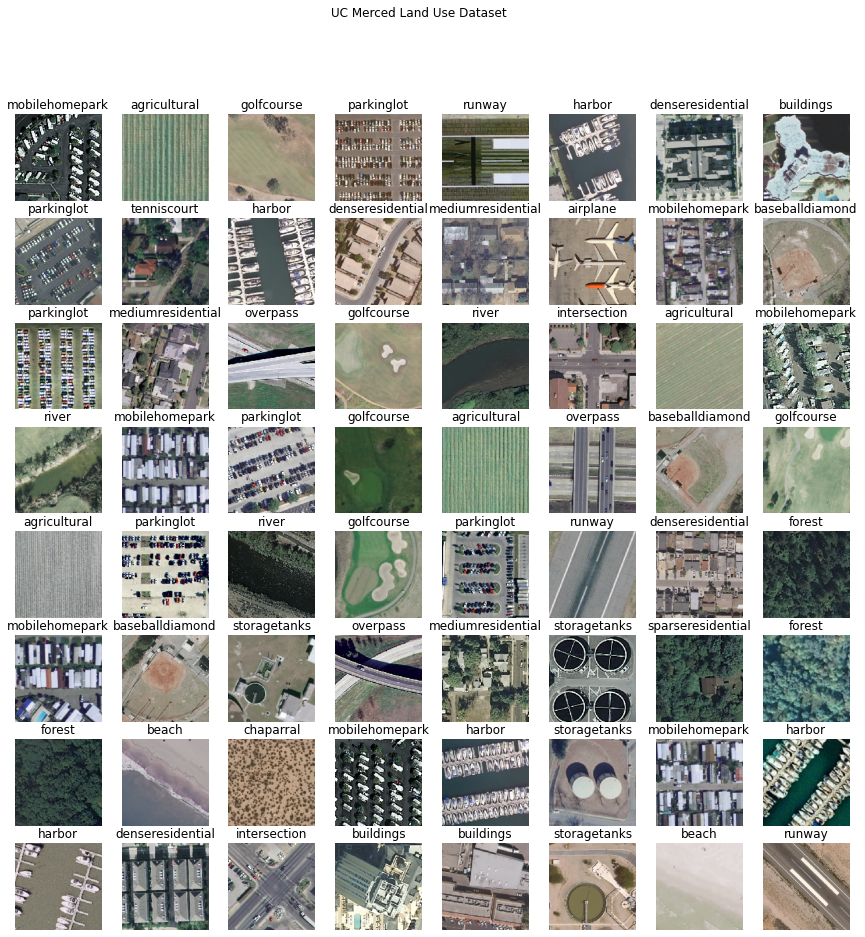

In [0]:
images, labels = next(cnn_train_images)
visualize_dataset(images, labels)

A basic CNN model is constructed.

In [0]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(*image_size, 3), name='C1'),
    keras.layers.MaxPooling2D((2, 2), name='M2'),
    keras.layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(*image_size, 3), name='C3'),
    keras.layers.MaxPooling2D((2, 2), name='M4'),
    keras.layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(*image_size, 3), name='C5'),
    keras.layers.MaxPooling2D((2, 2), name='M6'),
    keras.layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(*image_size, 3), name='C7'),
    keras.layers.MaxPooling2D((2, 2), name='M8'),
    keras.layers.Flatten(name='F9'),
    keras.layers.Dropout(0.4, name='D10'),
    keras.layers.Dense(64, activation='relu',
                       name='FC11'),
    keras.layers.Dense(num_classes, activation='softmax',
                       name='FC12')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 148, 148, 32)      896       
_________________________________________________________________
M2 (MaxPooling2D)            (None, 74, 74, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 72, 72, 64)        18496     
_________________________________________________________________
M4 (MaxPooling2D)            (None, 36, 36, 64)        0         
_________________________________________________________________
C5 (Conv2D)                  (None, 34, 34, 128)       73856     
_________________________________________________________________
M6 (MaxPooling2D)            (None, 17, 17, 128)       0         
_________________________________________________________________
C7 (Conv2D)                  (None, 15, 15, 128)       1

The model is compiled so as to make it trainable with an Adam (adaptive moment optimization is a variant of SGD algorithm which automatically adapts learning rates based on dataset and gradients across layers.) optimizer and the log likelihood based categorical Cross Entropy loss for multi-class classification with Softmax activations.

In [0]:
model.compile('adam', 'categorical_crossentropy',
              metrics=['accuracy'])

The model architecture is visualized.

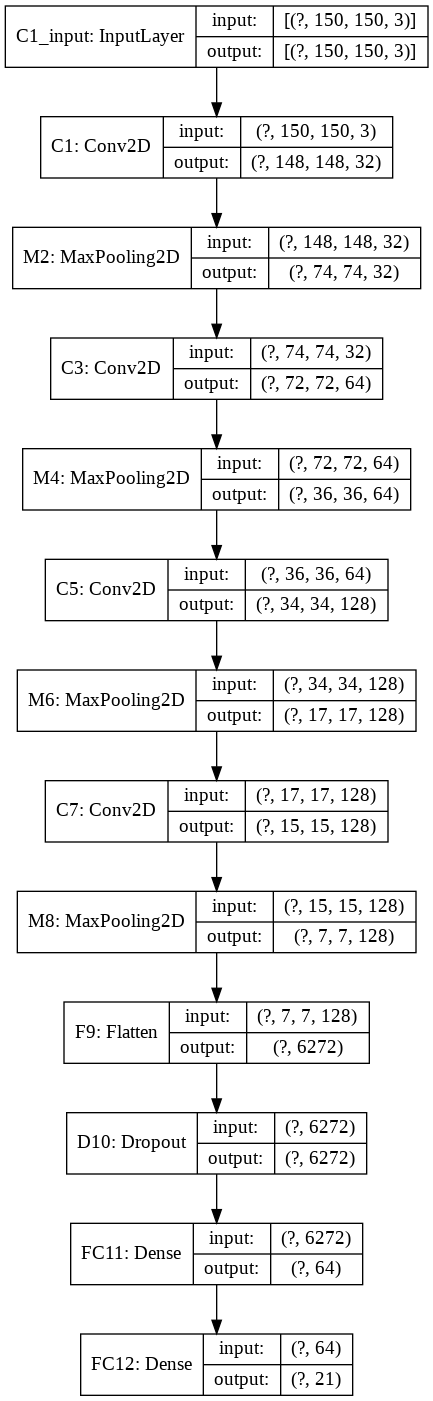

In [0]:
keras.utils.plot_model(model, show_shapes=True)

The CNN model is trained for a total of 20 epochs.

In [0]:
epochs = 20
train_steps = len(cnn_train_images)
val_steps = len(cnn_val_images)

In [0]:
history = model.fit(
    cnn_train_images, steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=cnn_val_images, validation_steps=val_steps)

Epoch 1/20
23/23 [==============================] - 5s 197ms/step - loss: 3.0135 - accuracy: 0.0599 - val_loss: 2.9607 - val_accuracy: 0.0508
Epoch 2/20
23/23 [==============================] - 3s 148ms/step - loss: 2.8452 - accuracy: 0.1041 - val_loss: 2.8356 - val_accuracy: 0.1397
Epoch 3/20
23/23 [==============================] - 4s 154ms/step - loss: 2.5554 - accuracy: 0.1769 - val_loss: 2.6105 - val_accuracy: 0.2048
Epoch 4/20
23/23 [==============================] - 3s 147ms/step - loss: 2.0605 - accuracy: 0.3218 - val_loss: 2.5171 - val_accuracy: 0.2270
Epoch 5/20
23/23 [==============================] - 3s 147ms/step - loss: 1.7623 - accuracy: 0.4109 - val_loss: 2.3797 - val_accuracy: 0.2921
Epoch 6/20
23/23 [==============================] - 3s 144ms/step - loss: 1.6260 - accuracy: 0.4701 - val_loss: 2.3657 - val_accuracy: 0.3397
Epoch 7/20
23/23 [==============================] - 3s 146ms/step - loss: 1.3389 - accuracy: 0.5585 - val_loss: 2.3469 - val_accuracy: 0.3429
Epoch 

We gather the epoch wise results of the complete training process.

In [0]:
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.xlabel('Epochs')
    plt.title('Loss')

    plt.show()

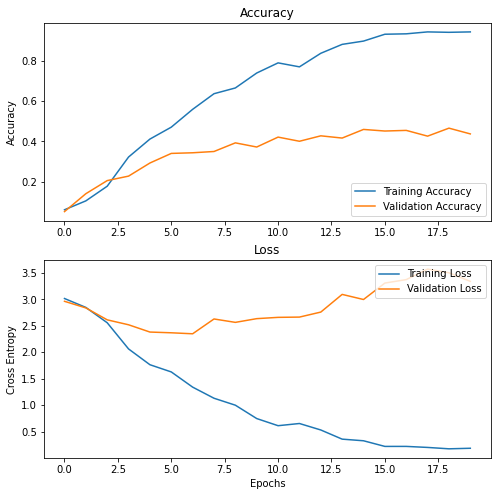

In [0]:
plot_training(history.history)

The tf.keras graph is reset to clear out any existing ops.

In [0]:
keras.backend.clear_session()

**VGG16**

*Simonyan, K. and Zisserman, A., 2014. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.*

We use a pre-trained VGG16 model trained on the ImageNet dataset as a fixed deep feature extractor. We freeze all the convolutional layers' weights by setting `base_model.trainable = False`, so as to ensure that these weights are not updated during training process.

The new model will be trained using transfer learning approach.

In [0]:
base_vgg16 = keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet',
    input_shape=(*image_size, 3)
)
base_vgg16.trainable = False

base_vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [0]:
model1 = keras.models.Sequential([
    base_vgg16,
    keras.layers.Flatten(name='F0'),
    keras.layers.Dense(4096, activation='relu', name='FC1'),
    keras.layers.Dense(4096, activation='relu', name='FC2'),
    keras.layers.Dense(num_classes, activation='softmax', name='Preds')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
F0 (Flatten)                 (None, 8192)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 4096)              33558528  
_________________________________________________________________
FC2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
Preds (Dense)                (None, 21)                86037     
Total params: 65,140,565
Trainable params: 50,425,877
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model1.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

Pre-trained models require that the new images are passed through the same preprocessing as at original images for training.

We ensure the same using the VGG16 specific preprocessing with our dataset during both training and validation.

In [0]:
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=val_size
)

In [0]:
vgg_train_images = vgg_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=True,
    subset='training'
)
vgg_val_images = vgg_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=False,
    subset='validation'
)

Found 1470 images belonging to 21 classes.
Found 630 images belonging to 21 classes.


The new model (with VGG16 as a fixed feature extractor) is trained for 20 epochs. Basically, the 3 dense layers present on top are trained for the classification task.

In [0]:
history = model1.fit(
    vgg_train_images, steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=vgg_val_images, 
    validation_steps=val_steps)

Epoch 1/20
23/23 [==============================] - 16s 681ms/step - loss: 22.2736 - accuracy: 0.5497 - val_loss: 1.0796 - val_accuracy: 0.7127
Epoch 2/20
23/23 [==============================] - 10s 419ms/step - loss: 0.5171 - accuracy: 0.9259 - val_loss: 0.9741 - val_accuracy: 0.7905
Epoch 3/20
23/23 [==============================] - 10s 420ms/step - loss: 0.0797 - accuracy: 0.9735 - val_loss: 1.1655 - val_accuracy: 0.7937
Epoch 4/20
23/23 [==============================] - 10s 420ms/step - loss: 0.0561 - accuracy: 0.9884 - val_loss: 1.7598 - val_accuracy: 0.7667
Epoch 5/20
23/23 [==============================] - 10s 420ms/step - loss: 0.0341 - accuracy: 0.9939 - val_loss: 1.8904 - val_accuracy: 0.7746
Epoch 6/20
23/23 [==============================] - 10s 421ms/step - loss: 0.0302 - accuracy: 0.9925 - val_loss: 1.7027 - val_accuracy: 0.7730
Epoch 7/20
23/23 [==============================] - 10s 423ms/step - loss: 0.1625 - accuracy: 0.9844 - val_loss: 1.5504 - val_accuracy: 0.792

The model training process is visualised with the help of loss and accuracy metrics.

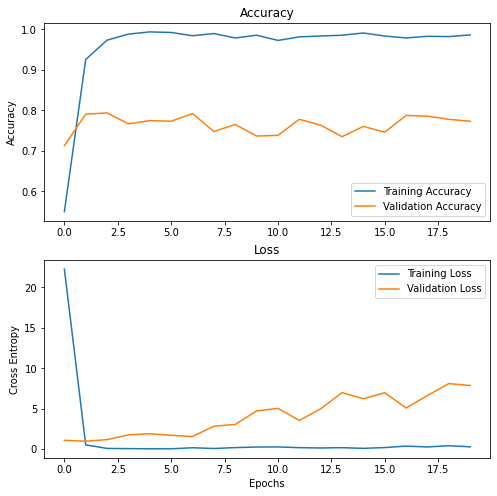

In [0]:
plot_training(history.history)

The tf.keras graph is reset again.

In [0]:
keras.backend.clear_session()

**Inception V3**

*Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J. and Wojna, Z., 2016. Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).*

We use another ImageNet pre-trained network. The InceptionV3 network composed of multiple Inception blocks is used similarly as a fixed deep feature extractor. 

This model requires lesser number of fully-connected layers to be trained for the new classification task. Moreover, it encourages use of Global Average Pooling layer (helps reduce dimensionality compared to the latter) instead of Flatten layer (as used in VGG16).

In [0]:
base_inception_v3 = keras.applications.inception_v3.InceptionV3(
    include_top=False, weights='imagenet',
    input_shape=(*image_size, 3)
)
base_inception_v3.trainable = False

base_inception_v3.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

In [0]:
model2 = keras.models.Sequential([
    base_inception_v3,
    keras.layers.GlobalAveragePooling2D(name='GAP'),
    keras.layers.Dense(num_classes, activation='softmax', name='Preds')
])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
Preds (Dense)                (None, 21)                43029     
Total params: 21,845,813
Trainable params: 43,029
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
model2.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

The InceptionV3 specific data preprocessing is applied on the images.

In [0]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

inception_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=val_size
)

In [0]:
inception_train_images = inception_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=True,
    subset='training'
)
inception_val_images = inception_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=False,
    subset='validation'
)

Found 1470 images belonging to 21 classes.
Found 630 images belonging to 21 classes.


The model is trained for 20 epochs.

In [0]:
history = model2.fit(
    inception_train_images, steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=inception_val_images, 
    validation_steps=val_steps)

Epoch 1/20
23/23 [==============================] - 9s 370ms/step - loss: 2.3048 - accuracy: 0.3687 - val_loss: 1.3674 - val_accuracy: 0.6143
Epoch 2/20
23/23 [==============================] - 4s 193ms/step - loss: 0.7451 - accuracy: 0.8272 - val_loss: 0.9153 - val_accuracy: 0.7444
Epoch 3/20
23/23 [==============================] - 4s 192ms/step - loss: 0.4204 - accuracy: 0.9190 - val_loss: 0.7917 - val_accuracy: 0.7762
Epoch 4/20
23/23 [==============================] - 4s 192ms/step - loss: 0.2686 - accuracy: 0.9578 - val_loss: 0.7429 - val_accuracy: 0.7825
Epoch 5/20
23/23 [==============================] - 4s 193ms/step - loss: 0.1930 - accuracy: 0.9830 - val_loss: 0.6946 - val_accuracy: 0.7905
Epoch 6/20
23/23 [==============================] - 4s 193ms/step - loss: 0.1441 - accuracy: 0.9891 - val_loss: 0.6656 - val_accuracy: 0.7921
Epoch 7/20
23/23 [==============================] - 4s 192ms/step - loss: 0.1131 - accuracy: 0.9946 - val_loss: 0.6247 - val_accuracy: 0.8032
Epoch 

Upon visualization of the training graphs, it can be asserted that this model is less prone to overfitting than VGG16 model because of presence of lesser number of fully connected layers on top.

Also, Inception based architectures are known to benefit from lower computational complexity yet yielding better classification accuracy.

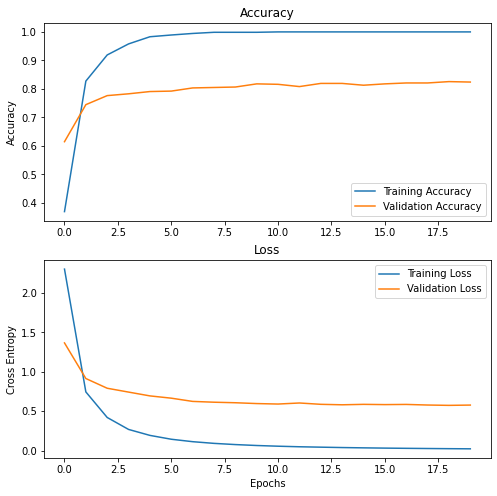

In [0]:
plot_training(history.history)

The tf.keras graph is reset again to clear existing models from the computational graph.

In [0]:
keras.backend.clear_session()

**ResNet50**

*He, K., Zhang, X., Ren, S. and Sun, J., 2016. Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).*

Residual learning aims to ease the network learning process by use of residual connection blocks. For many applications, such residual networks better accuracy at reduced computational costs. 

The ResNet50 pre-trained model is used as a fixed deep feature extractor here. The terminal dense layer is used to learn the new classification problem on our dataset during training process.

In [0]:
base_resnet50 = keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet',
    input_shape=(*image_size, 3)
)
base_resnet50.trainable = False

base_resnet50.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
__________________________

In [0]:
model3 = keras.models.Sequential([
    base_resnet50,
    keras.layers.GlobalAveragePooling2D(name='GAP'),
    keras.layers.Dense(num_classes, activation='softmax', name='Preds')
])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
Preds (Dense)                (None, 21)                43029     
Total params: 23,630,741
Trainable params: 43,029
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
model3.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

The ResNet50 specfic image preprocessing function is passed as an argument to the image data generator.

In [0]:
from tensorflow.keras.applications.resnet50 import preprocess_input

resnet_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=val_size
)

In [0]:
resnet_train_images = resnet_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=True,
    subset='training'
)
resnet_val_images = resnet_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=False,
    subset='validation'
)

Found 1470 images belonging to 21 classes.
Found 630 images belonging to 21 classes.


In [0]:
history = model3.fit(
    resnet_train_images, steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=resnet_val_images, 
    validation_steps=val_steps)

Epoch 1/20
23/23 [==============================] - 11s 465ms/step - loss: 1.6427 - accuracy: 0.5374 - val_loss: 0.7397 - val_accuracy: 0.7651
Epoch 2/20
23/23 [==============================] - 8s 342ms/step - loss: 0.3031 - accuracy: 0.9204 - val_loss: 0.5103 - val_accuracy: 0.8302
Epoch 3/20
23/23 [==============================] - 8s 343ms/step - loss: 0.1571 - accuracy: 0.9680 - val_loss: 0.4490 - val_accuracy: 0.8556
Epoch 4/20
23/23 [==============================] - 8s 341ms/step - loss: 0.0979 - accuracy: 0.9844 - val_loss: 0.4482 - val_accuracy: 0.8476
Epoch 5/20
23/23 [==============================] - 8s 339ms/step - loss: 0.0703 - accuracy: 0.9925 - val_loss: 0.4319 - val_accuracy: 0.8508
Epoch 6/20
23/23 [==============================] - 8s 343ms/step - loss: 0.0522 - accuracy: 0.9980 - val_loss: 0.4340 - val_accuracy: 0.8476
Epoch 7/20
23/23 [==============================] - 8s 339ms/step - loss: 0.0421 - accuracy: 0.9986 - val_loss: 0.4099 - val_accuracy: 0.8571
Epoch

Model training process is visualised with the help of loss and accuracy plots.

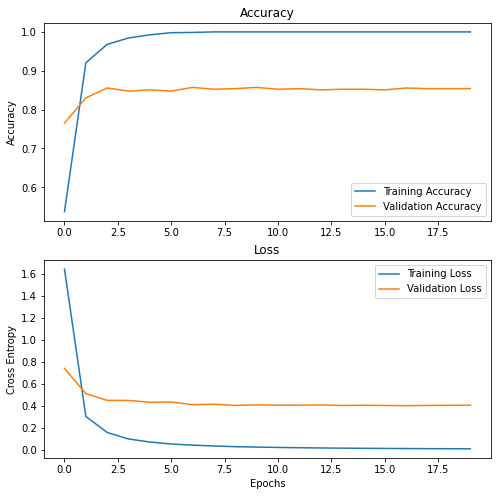

In [0]:
plot_training(history.history)

**Data Augmentation**

Random affine transformations are applied on training images to generate random samples  which are known to improve regularization of deep learning models especially, on transfer learning based tasks.

The random samples are generated on the fly which increase the number of total training samples using data generator. It helps augment our dataset and reduce over fitting of the model.

In [0]:
from tensorflow.keras.applications.resnet50 import preprocess_input

resnet_aug_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.3,
    zoom_range=0.3,

    preprocessing_function=preprocess_input,
    validation_split=val_size
)

It is important to not use data augmentation for the validation dataset as it'd be used to evaluate performance of the classifier only.

In [0]:
resnet_aug_train_images = resnet_aug_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=True,
    subset='training'
)

# not using augmentation in validation set
resnet_val_images = resnet_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=False,
    subset='validation'
)

Found 1470 images belonging to 21 classes.
Found 630 images belonging to 21 classes.


The preprocessing applied to the data generator as a part of the model training pipeline uses ImageNet mean normalization in case of ResNet50. 

A few set of augmented images are to be visualized which would require that the mean normalization step as a part of pre-processing be rolled back.

In [0]:
def reverse_preprocess(x):
    mean = [103.939, 116.779, 123.68]
    x += mean # mean is added
    x = x[..., ::-1] # BGR to RGB

    # x is in range (0, 255.0)
    x /= 255. # x is in range (0, 1.)

    return x

The augmented images with random affine transformations applied on the actual dataset are visualised.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

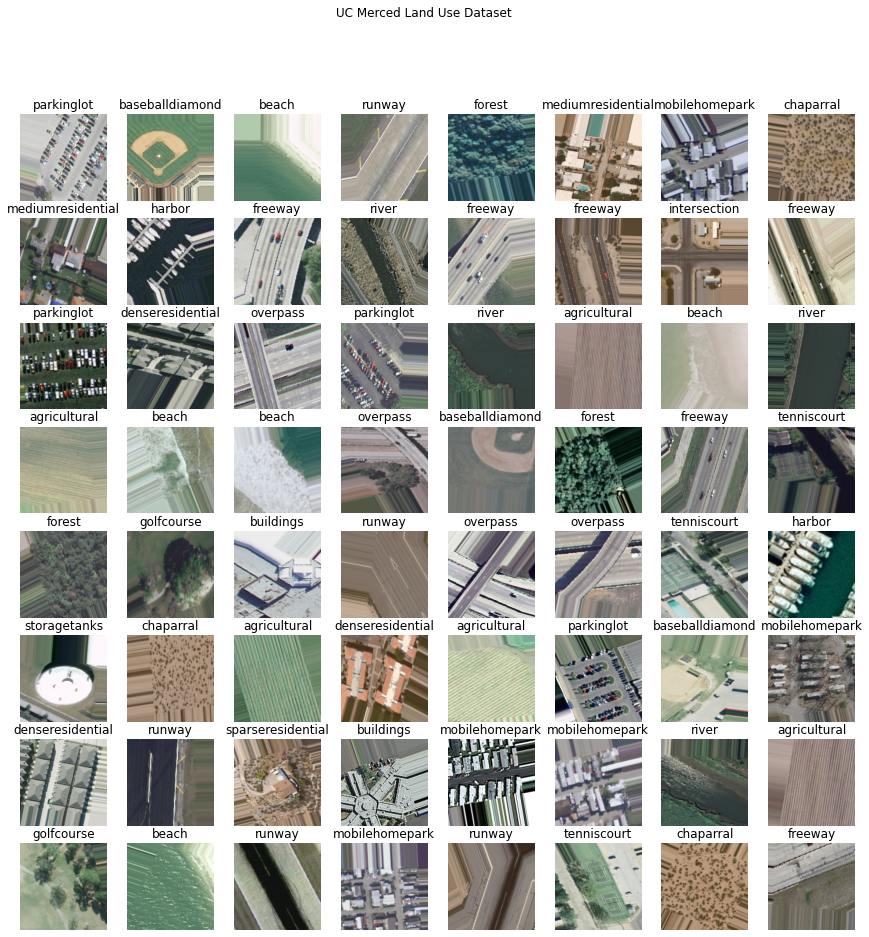

In [0]:
images, labels = next(resnet_aug_train_images)
images = reverse_preprocess(images)

visualize_dataset(images, labels)

Fine-tuning is the process of adjusting the weights of certain layers of our model basis previously learned weights such that it makes our model well suited to our classification problem. 

In this transfer learning based fine tuning approach, we fine tune the weights of the each convolutional layer of our ResNet50 model so as to achieve better classification performance. The ResNet50 model weights are unfrozen by using `base_model.trainable = True`.

In [0]:
base_resnet50.trainable = True

model4 = keras.models.Sequential([
    base_resnet50,
    keras.layers.GlobalAveragePooling2D(name='GAP'),
    keras.layers.Dense(num_classes, activation='softmax', name='Preds')
])
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
Preds (Dense)                (None, 21)                43029     
Total params: 23,630,741
Trainable params: 23,577,621
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
model4.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

This model will be trained for a total of 50 epochs as data augmentation have been applied which will prevent the model to overfit. The model would benefit from being trained over a very large set of randomly generated / augmented images.

In [0]:
epochs = 50

So as to preserve the knowledge already learnt by a pre-trained model, we use a learning rate schedule starting from a low learning rate and ensures that the model learning rate increases gradually.

The learning rate initially increases linearly for the first 15 warmup epochs and then to prevent any overfitting it decreases using exponential decay rate of 0.8.

In [0]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 15
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]

The variation of learning rate across epochs is visualised using a plot.

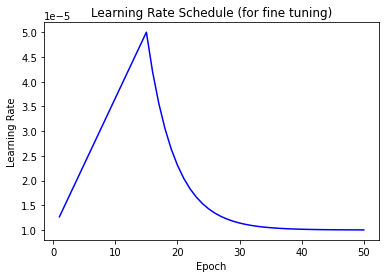

In [0]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

The complete model is trained such that weights of each layer are updated during the training process. Fine tuning will ensure that the whole network well suits to the new classification task.

In [0]:
history = model4.fit(
    resnet_aug_train_images, steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=resnet_val_images, 
    validation_steps=val_steps, callbacks=cbs)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
23/23 [==============================] - 21s 926ms/step - loss: 3.1993 - accuracy: 0.1027 - val_loss: 3.2747 - val_accuracy: 0.1159 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2666666666666668e-05.
Epoch 2/50
23/23 [==============================] - 19s 810ms/step - loss: 2.4310 - accuracy: 0.3000 - val_loss: 2.4347 - val_accuracy: 0.2984 - lr: 1.2667e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5333333333333334e-05.
Epoch 3/50
23/23 [==============================] - 19s 810ms/step - loss: 1.7638 - accuracy: 0.5320 - val_loss: 1.7293 - val_accuracy: 0.5000 - lr: 1.5333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 4/50
23/23 [==============================] - 19s 813ms/step - loss: 1.2033 - accuracy: 0.7041 - val_loss: 1.2288 - val_accuracy: 0.6365 - lr: 1.8000e-05

Epoch 00005: LearningRateSchedul

The training process is again visualised.

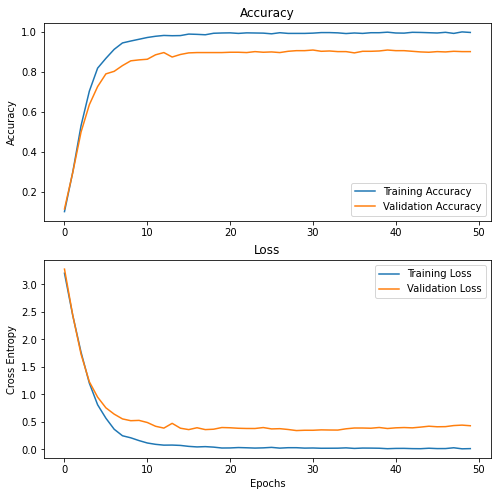

In [0]:
plot_training(history.history)

**Exploring Further**

- fine tuning only selected set of layers instead of complete network (https://www.tensorflow.org/tutorials/images/transfer_learning)
- serializing models together with preprocessing ops as model layers (https://keras.io/guides/transfer_learning/)
- applying automatically adaptive data augmentation strategies (https://ai.googleblog.com/2018/06/improving-deep-learning-performance.html)
- more advanced architectures like SqueezeNet, DenseNet, EfficientNet (http://cs231n.stanford.edu/slides/2020/lecture_9.pdf)


**References**
- *Abadi, M., Barham, P., Chen, J., Chen, Z., Davis, A., Dean, J., Devin, M., Ghemawat, S., Irving, G., Isard, M. and Kudlur, M., 2016. Tensorflow: A system for large-scale machine learning. In 12th {USENIX} Symposium on Operating Systems Design and Implementation ({OSDI} 16) (pp. 265-283).*
- *Hunter, J.D., 2007. Matplotlib: A 2D graphics environment. Computing in science & engineering, 9(3), pp.90-95.*
- *Walt, S.V.D., Colbert, S.C. and Varoquaux, G., 2011. The NumPy array: a structure for efficient numerical computation. Computing in Science & Engineering, 13(2), pp.22-30.*
- *Chollet, F., 2018. Deep Learning with Python: Das Praxis-Handbuch vom Entwickler der Keras-Bibliothek. MITP-Verlags GmbH & Co. KG.*
- *Géron, A., 2019. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O'Reilly Media.*
- *Simonyan, K. and Zisserman, A., 2014. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.*
- *He, K., Zhang, X., Ren, S. and Sun, J., 2016. Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).*
- *Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J. and Wojna, Z., 2016. Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).*
- *Yang, Y. and Newsam, S., 2010, November. Bag-of-visual-words and spatial extensions for land-use classification. In Proceedings of the 18th SIGSPATIAL international conference on advances in geographic information systems (pp. 270-279).*
